# Install Libs

In [ ]:
!pip install llama-index-agent-introspective
!pip install llama-index-llms-openai
!pip install llama-index-program-openai
!pip install llama-index-readers-file

Mounted at /content/drive


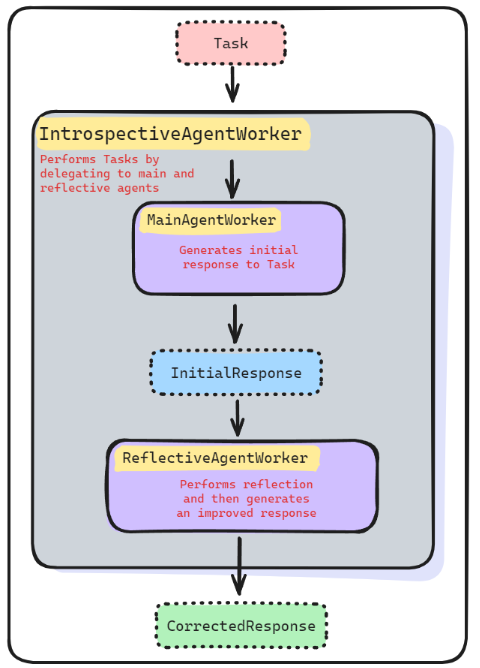

In [1]:
from IPython.display import Image
image_url = local_path + 'introspective_agent_worker.png'
Image(image_url)

# Specifying Tools: Get historical prices

In [ ]:
from llama_index.core.tools.tool_spec.base import BaseToolSpec
import yfinance as yf
import pandas as pd
from datetime import date
from datetime import datetime

class FinanceTools(BaseToolSpec):
    """Finance tools spec."""

    #Only one tool example for this notebook tutorial
    spec_functions = [
        "stock_prices",
    ]

    def __init__(self) -> None:
        """Initialize the Yahoo Finance tool spec."""

    def stock_prices(self, ticker: str, start_date : str, end_date = datetime.today().strftime('%Y-%m-%d')) -> pd.DataFrame:
            """
            Get the historical prices and volume for a ticker from start_date to end_date.

            Args:
              ticker (str): the stock ticker to be given to yfinance
              start_date (str): the start date in the format YYYY-MM-DD
              end_date (str): the end date in the format YYYY-MM-DD
            """
            stock = yf.Ticker(ticker)
            df = yf.download(ticker, start=start_date, end=end_date)

            return df



In [ ]:
finance_tool = FinanceTools()

finance_tool_list = finance_tool.to_tool_list()

stock_prices
plot_stock_price


In [ ]:
from google.colab import userdata
import os
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

Source from LlamaIndex: https://docs.llamaindex.ai/en/latest/examples/agent/introspective_agent_toxicity_reduction/?h=agents

# Introspective Agent With Tool Interactive Reflection:

In [ ]:
from llama_index.agent.introspective import ToolInteractiveReflectionAgentWorker, IntrospectiveAgentWorker
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.llms.openai import OpenAI
from llama_index.agent.openai import OpenAIAgentWorker
from llama_index.core.llms import ChatMessage, MessageRole

def get_introspective_agent_with_tool_interactive_reflection(
    verbose=True, with_main_worker=True
):
    """Helper function for building introspective agent using tool-interactive reflection.

    Steps:

    1. Define the `ToolInteractiveReflectionAgentWorker`
        1a. Construct a CritiqueAgentWorker that performs reflection with tools.
        1b. Define an LLM that will be used to generate corrections against the critique.
        1c. Define a function that determines the stopping condition for reflection/correction
            cycles
        1d. Construct `ToolInteractiveReflectionAgentWorker` using .from_defaults()

    2. Optionally define a `MainAgentWorker`

    3. Construct `IntrospectiveAgent`
        3a. Construct `IntrospectiveAgentWorker` using .from_defaults()
        3b. Construct `IntrospectiveAgent` using .as_agent()
    """

    # 1a.
    critique_agent_worker = FunctionCallingAgentWorker.from_tools(
        tools=finance_tool_list, llm=OpenAI("gpt-3.5-turbo"), verbose=verbose
    )
    # 1b.
    correction_llm = OpenAI("gpt-4-turbo-preview")

    # 1c.
    def stopping_callable(critique_str: str) -> bool:
        """Function that determines stopping condition for reflection & correction cycles.

        critique_str [str]: The response string provided by the critique agent.
        """

        return "[PASS]" in critique_str

    # 1d.
    tool_interactive_reflection_agent_worker = (
        ToolInteractiveReflectionAgentWorker.from_defaults(
            critique_agent_worker=critique_agent_worker,
            critique_template=(
                "Retrieve the exact interval times of historical prices as requested by the user."
                "Check the code carefully for correctness, style, and efficiency, and give constructive criticism for how to improve it. "
                "write '[PASS]' otherwise write '[FAIL]'. "
                "Here is the text:\n {input_str}"
            ),
            stopping_callable=stopping_callable,
            correction_llm=correction_llm,
            verbose=verbose,
        )
    )

    # 2.
    if with_main_worker:
        main_agent_worker = OpenAIAgentWorker.from_tools(
            tools=finance_tool_list, llm=OpenAI("gpt-4-turbo-preview"), verbose=True
        )
    else:
        main_agent_worker = None

    # 3a.
    introspective_agent_worker = IntrospectiveAgentWorker.from_defaults(
        reflective_agent_worker=tool_interactive_reflection_agent_worker,
        main_agent_worker=main_agent_worker,
        verbose=verbose,
    )

    chat_history = [
        ChatMessage(
            content="You are a financial assistant that helps answering questions to gather historical prices and propose Python implementation of trading strategies.",
            role=MessageRole.SYSTEM,
        )
    ]

    # 3b.
    return introspective_agent_worker.as_agent(
        chat_history=chat_history, verbose=verbose
    )


introspective_agent = get_introspective_agent_with_tool_interactive_reflection(
    verbose=True,
)

## Using Agent Worker : with_main_worker=True

In [ ]:
# Without sepcifying the agent worker TOOLS:
        # main_agent_worker = OpenAIAgentWorker.from_tools(
        #     tools=[], llm=OpenAI("gpt-4-turbo-preview"), verbose=True
        # )

query="""Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices."""
response = await introspective_agent.achat(query)
#The critic agent didn't use the Tools to answer the question, instead, it proposes a Python code to fetch data.

> Running step cb4a2bff-a518-4130-8454-864b396fad66. Step input: Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices.
> Running step 1dc516ab-c64b-4afa-b7db-414feb465a45. Step input: Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices.
Added user message to memory: Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices.
> Running step f7252f72-647f-4aa9-aead-de8710a54130. Step input: I'm unable to directly access or retrieve real-time data, including historical prices for BTCUSD or any other financial instruments. However, I can guide you on how to obtain this data using Python and the `pandas` library along with a financial data provider like Yahoo Finance.

Here's a Python code snippet that uses the `yfinance` library to fetch the last 3 months of historical close prices for BTCUSD. If you haven't ins

In [ ]:
# By sepcifying the agent worker TOOLS:
        # main_agent_worker = OpenAIAgentWorker.from_tools(
        #     tools=finance_tool_list, llm=OpenAI("gpt-4-turbo-preview"), verbose=True
        # )

query="""Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices."""
response = await introspective_agent.achat(query)
#The first attempt of the agent worker was not correct as it gives historical prices starting 01 of September.
# The critic agent didn't succeed either: Fail to detect the right ticker symbol (even if the agent worker succeed).
# However it proposes a Python code to fetch data (with the right ticker).

> Running step 55091f35-5014-4cf7-84e2-c0fe075ce18b. Step input: Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices.
> Running step c3d7f3ea-718b-41f8-8948-4b5f69d8cb67. Step input: Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices.
Added user message to memory: Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices.


[*********************100%%**********************]  1 of 1 completed

=== Calling Function ===
Calling function: stock_prices with args: {"ticker":"BTC-USD","start_date":"2023-09-01"}
Got output:                     Open          High           Low         Close  \
Date                                                                 
2023-09-01  25934.021484  26125.869141  25362.609375  25800.724609   
2023-09-02  25800.910156  25970.285156  25753.093750  25868.798828   
2023-09-03  25869.472656  26087.148438  25817.031250  25969.566406   
2023-09-04  25968.169922  26081.525391  25657.025391  25812.416016   
2023-09-05  25814.957031  25858.375000  25589.988281  25779.982422   
...                  ...           ...           ...           ...   
2024-04-30  63839.417969  64703.332031  59120.066406  60636.855469   
2024-05-01  60609.496094  60780.500000  56555.292969  58254.011719   
2024-05-02  58253.703125  59602.296875  56937.203125  59123.433594   
2024-05-03  59122.300781  63320.503906  58848.312500  62889.835938   
2024-05-04  62891.031250  64494.95

> Running step f26ade51-5177-4ffc-858f-b3b4ac41311a. Step input: The dataframe with the historical close prices of BTCUSD for the last 3 months is as follows:

| Date       | Close       |
|------------|-------------|
| 2023-09-01 | 25800.724609|
| 2023-09-02 | 25868.798828|
| 2023-09-03 | 25969.566406|
| 2023-09-04 | 25812.416016|
| 2023-09-05 | 25779.982422|
| ...        | ...         |
| 2024-04-30 | 60636.855469|
| 2024-05-01 | 58254.011719|
| 2024-05-02 | 59123.433594|
| 2024-05-03 | 62889.835938|
| 2024-05-04 | 63891.472656|

Please note that this table is truncated for brevity.
> Running step 53f88088-b316-453e-b27d-e86d908da64f. Step input: Retrieve the exact interval times of historical prices as requested by the user.Check the code carefully for correctness, style, and efficiency, and give constructive criticism for how to improve it. write '[PASS]' otherwise write '[FAIL]'. Here is the text:
 The dataframe with the historical close prices of BTCUSD for the last 3 months is a

[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BTCUSD']: Exception('%ticker%: No timezone found, symbol may be delisted')


=== Function Output ===
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
> Running step 507a3cd4-1286-4e66-80bb-0cfc18d6d3ae. Step input: None
=== LLM Response ===
[FAIL] The code failed to retrieve the historical prices for BTCUSD from the specified start date to end date. The returned DataFrame is empty, indicating that there was an issue with fetching the data.
Critique: assistant: [FAIL] The code failed to retrieve the historical prices for BTCUSD from the specified start date to end date. The returned DataFrame is empty, indicating that there was an issue with fetching the data.
Correction: The attempt to retrieve the historical close prices of BTCUSD for the last 3 months resulted in an empty DataFrame, indicating a failure in fetching the data from the specified start date to end date.
> Running step 56d0b4c2-c472-4c56-a744-5e42bc0df822. Step input: None
> Running step 2e4f223e-adb1-4162-b1bd-102bdb9dab71. Step input: Retrieve the exact interval tim

[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BTCUSD']: Exception('%ticker%: No timezone found, symbol may be delisted')


=== Calling Function ===
Calling function: stock_prices with args: {"ticker": "BTCUSD", "start_date": "2024-02-06", "end_date": "2024-05-06"}
=== Function Output ===
Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
> Running step c5fee091-7f84-4bc3-acec-98044d22d207. Step input: None
=== LLM Response ===
[FAIL] - The attempt to retrieve the historical close prices of BTCUSD for the last 3 months resulted in an empty DataFrame, indicating a failure in fetching the data from the specified start date to end date.
Critique: assistant: [FAIL] - The attempt to retrieve the historical close prices of BTCUSD for the last 3 months resulted in an empty DataFrame, indicating a failure in fetching the data from the specified start date to end date.
Correction: The attempt to retrieve the historical close prices of BTCUSD for the last 3 months resulted in an empty DataFrame, indicating a failure in fetching the data from the specified start date to end date.
> Running 

## Not Using Agent Worker : with_main_worker=False

Good results

In [ ]:
query="""Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices."""
response = await introspective_agent.achat(query)
#The final anwser is good

> Running step e6b4d08a-4371-4383-ae44-f092d8a45bc9. Step input: Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices.
Added user message to memory: Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices.
> Running step eea5e45b-1e1b-4b0b-a06a-83171ea8105c. Step input: Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices.
> Running step a84ede66-6ec6-4711-865e-247182a815c2. Step input: Check the code carefully for correctness, style, and efficiency, and give constructive criticism for how to improve it. write '[PASS]' otherwise write '[FAIL]'. Here is the text:
 Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices.
Added user message to memory: Check the code carefully for correctness, style, and efficiency, and give constructive criticism for 

[*********************100%%**********************]  1 of 1 completed


=== Function Output ===
                    Open          High           Low         Close  \
Date                                                                 
2024-02-06  42657.390625  43344.148438  42529.019531  43084.671875   
2024-02-07  43090.019531  44341.949219  42775.957031  44318.222656   
2024-02-08  44332.125000  45575.839844  44332.125000  45301.566406   
2024-02-09  45297.382812  48152.496094  45260.824219  47147.199219   
2024-02-10  47153.527344  48146.171875  46905.320312  47771.277344   
...                  ...           ...           ...           ...   
2024-04-30  63839.417969  64703.332031  59120.066406  60636.855469   
2024-05-01  60609.496094  60780.500000  56555.292969  58254.011719   
2024-05-02  58253.703125  59602.296875  56937.203125  59123.433594   
2024-05-03  59122.300781  63320.503906  58848.312500  62889.835938   
2024-05-04  62891.031250  64494.957031  62599.351562  63891.472656   

               Adj Close       Volume  
Date                     

[*********************100%%**********************]  1 of 1 completed

=== Calling Function ===
Calling function: stock_prices with args: {"ticker": "BTC-USD", "start_date": "2024-02-06", "end_date": "2024-05-06"}
=== Function Output ===
                    Open          High           Low         Close  \
Date                                                                 
2024-02-06  42657.390625  43344.148438  42529.019531  43084.671875   
2024-02-07  43090.019531  44341.949219  42775.957031  44318.222656   
2024-02-08  44332.125000  45575.839844  44332.125000  45301.566406   
2024-02-09  45297.382812  48152.496094  45260.824219  47147.199219   
2024-02-10  47153.527344  48146.171875  46905.320312  47771.277344   
...                  ...           ...           ...           ...   
2024-04-30  63839.417969  64703.332031  59120.066406  60636.855469   
2024-05-01  60609.496094  60780.500000  56555.292969  58254.011719   
2024-05-02  58253.703125  59602.296875  56937.203125  59123.433594   
2024-05-03  59122.300781  63320.503906  58848.312500  62889.835

=== LLM Response ===
[PASS]
Critique: assistant: [PASS]


The first attempt was correct, I don't understand why the agent understands that it failed.

Critique: assistant: [FAIL] The response includes the historical close prices of BTC-USD for the entire period from February 6, 2024, to May 4, 2024, instead of just the last 3 months.

It's indeed 3 months

In [ ]:
list_resp = response.sources

In [ ]:
list_resp[0].raw_output

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-06,42657.390625,43344.148438,42529.019531,43084.671875,43084.671875,16798476726
2024-02-07,43090.019531,44341.949219,42775.957031,44318.222656,44318.222656,21126587775
2024-02-08,44332.125000,45575.839844,44332.125000,45301.566406,45301.566406,26154524080
2024-02-09,45297.382812,48152.496094,45260.824219,47147.199219,47147.199219,39316770844
2024-02-10,47153.527344,48146.171875,46905.320312,47771.277344,47771.277344,16398681570
...,...,...,...,...,...,...
2024-04-30,63839.417969,64703.332031,59120.066406,60636.855469,60636.855469,37840840057
2024-05-01,60609.496094,60780.500000,56555.292969,58254.011719,58254.011719,48439780271
2024-05-02,58253.703125,59602.296875,56937.203125,59123.433594,59123.433594,32711813559


# When Using Only One Agent Worker with Tools: Without Introspective Agent

In [ ]:
main_agent_worker = OpenAIAgentWorker.from_tools(
            tools=finance_tool_list, llm=OpenAI("gpt-4-turbo-preview"), verbose=True
        )

chat_history = [
        ChatMessage(
            content="You are a financial assistant that helps answering questions to gather historical prices and propose Python implementation of trading strategies.",
            role=MessageRole.SYSTEM,
        )
 ]

agent_worker = main_agent_worker.as_agent(
        chat_history=chat_history, verbose=True
    )

query="""Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices."""
response3 = await agent_worker.achat(query)

> Running step dba6eba2-3a65-4466-9a5f-29f6772dbf18. Step input: Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices.
Added user message to memory: Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices.
=== Calling Function ===
Calling function: stock_prices with args: {"ticker":"BTC-USD","start_date":"2023-09-01"}


[*********************100%%**********************]  1 of 1 completed


Got output:                     Open          High           Low         Close  \
Date                                                                 
2023-09-01  25934.021484  26125.869141  25362.609375  25800.724609   
2023-09-02  25800.910156  25970.285156  25753.093750  25868.798828   
2023-09-03  25869.472656  26087.148438  25817.031250  25969.566406   
2023-09-04  25968.169922  26081.525391  25657.025391  25812.416016   
2023-09-05  25814.957031  25858.375000  25589.988281  25779.982422   
...                  ...           ...           ...           ...   
2024-04-30  63839.417969  64703.332031  59120.066406  60636.855469   
2024-05-01  60609.496094  60780.500000  56555.292969  58254.011719   
2024-05-02  58253.703125  59602.296875  56937.203125  59123.433594   
2024-05-03  59122.300781  63320.503906  58848.312500  62889.835938   
2024-05-04  62891.031250  64494.957031  62599.351562  63891.472656   

               Adj Close       Volume  
Date                                 

The results are not good because it didn't generate only the prices of the last 3 months...but much more starting from September 2023

# With Self Reflection agent:

The intuition here is that if you don't specify any tool (as in the example notebook from LlamaIndex), you will not have any answer ==> However, let's sepcify the tools in the agent worker and see if the self reflection agent will help:

In [ ]:
from llama_index.agent.introspective import SelfReflectionAgentWorker


def get_introspective_agent_with_self_reflection(
    verbose=True, with_main_worker=True
):
    """Helper function for building introspective agent using self reflection.

    Steps:

    1. Define the `SelfReflectionAgentWorker`
        1a. Construct `SelfReflectionAgentWorker` using .from_defaults()

    2. Optionally define a `MainAgentWorker`

    3. Construct `IntrospectiveAgent`
        3a. Construct `IntrospectiveAgentWorker` using .from_defaults()
        3b. Construct `IntrospectiveAgent` using .as_agent()
    """

    # 1a.
    self_reflection_agent_worker = SelfReflectionAgentWorker.from_defaults(
        llm=OpenAI("gpt-4-turbo-preview"),
        verbose=verbose,
    )

    # 2.
    if with_main_worker:
        main_agent_worker = OpenAIAgentWorker.from_tools(
            tools=finance_tool_list, llm=OpenAI("gpt-4-turbo-preview"), verbose=True
        )
    else:
        main_agent_worker = None

    # 3a.
    introspective_worker_agent = IntrospectiveAgentWorker.from_defaults(
        reflective_agent_worker=self_reflection_agent_worker,
        main_agent_worker=main_agent_worker,
        verbose=verbose,
    )

    chat_history = [
        ChatMessage(
            content="You are a financial assistant that helps answering questions to gather historical prices and propose Python implementation of trading strategies.",
            role=MessageRole.SYSTEM,
        )
    ]

    # 3b.
    return introspective_worker_agent.as_agent(
        chat_history=chat_history, verbose=verbose
    )


introspective_agent_self_reflection = get_introspective_agent_with_self_reflection(
    verbose=True
)

In [ ]:
query="""Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices."""
response2 = await introspective_agent_self_reflection.achat(query)

> Running step 049fb341-f337-48f1-ba78-74625a97d3e5. Step input: Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices.
> Running step 5e8ac812-c022-40c5-ace4-056d9f2287c8. Step input: Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices.
Added user message to memory: Give me the last 3 months historical close prices of BTCUSD. Respond only with the dataframe with the close prices.


[*********************100%%**********************]  1 of 1 completed

=== Calling Function ===
Calling function: stock_prices with args: {"ticker":"BTC-USD","start_date":"2023-09-01"}
Got output:                     Open          High           Low         Close  \
Date                                                                 
2023-09-01  25934.021484  26125.869141  25362.609375  25800.724609   
2023-09-02  25800.910156  25970.285156  25753.093750  25868.798828   
2023-09-03  25869.472656  26087.148438  25817.031250  25969.566406   
2023-09-04  25968.169922  26081.525391  25657.025391  25812.416016   
2023-09-05  25814.957031  25858.375000  25589.988281  25779.982422   
...                  ...           ...           ...           ...   
2024-04-30  63839.417969  64703.332031  59120.066406  60636.855469   
2024-05-01  60609.496094  60780.500000  56555.292969  58254.011719   
2024-05-02  58253.703125  59602.296875  56937.203125  59123.433594   
2024-05-03  59122.300781  63320.503906  58848.312500  62889.835938   
2024-05-04  62891.031250  64494.95

> Running step 891577e2-eea5-417d-99d4-7ab72d84966a. Step input: Here are the last 3 months of historical close prices for BTC-USD:

| Date       | Close       |
|------------|-------------|
| 2023-09-01 | 25800.724609|
| 2023-09-02 | 25868.798828|
| 2023-09-03 | 25969.566406|
| ...        | ...         |
| 2024-04-30 | 60636.855469|
| 2024-05-01 | 58254.011719|
| 2024-05-02 | 59123.433594|
| 2024-05-03 | 62889.835938|
| 2024-05-04 | 63891.472656|

(Note: The table above is a summary and does not include all dates within the last 3 months.)
> Reflection: {'is_done': False, 'feedback': "The assistant correctly used the tool to fetch the historical close prices for BTC-USD, but the final output includes data beyond the last 3 months requested by the user. The assistant should have filtered the data to only include the last 3 months from the current date. Additionally, the assistant's final message does not provide a complete solution as it mentions the table is a summary and does not inc

The results are not good because it didn't generate only the prices of the last 3 months...but much more starting from September 2023